In [78]:
import pandas as pd
import numpy as np

primaryBusData = pd.read_csv('/Users/ghostcookie/pythonProjects2025/MTA_Bus_Automated_Camera_Enforcement_Violations__Beginning_October_2019_20250919.csv')
cunyData = pd.read_csv('/Users/ghostcookie/pythonProjects2025/City_University_of_New_York__CUNY__University_Campus_Locations_20250923.csv')

In [79]:
#### HYPOTHESIS ####

In [80]:
print(primaryBusData.columns) #check column names
primaryBusData = primaryBusData.rename(columns={'Violation Status':'Violation_Status', 'Violation Type':'Violation_Type', 'Violation Latitude':'Violation_Latitude', 'Violation Longitude':'Violation_Longitude', 'First Occurrence':'First_Occurrence'})

Index(['Violation ID', 'Vehicle ID', 'First Occurrence', 'Last Occurrence',
       'Violation Status', 'Violation Type', 'Bus Route ID',
       'Violation Latitude', 'Violation Longitude', 'Stop ID', 'Stop Name',
       'Bus Stop Latitude', 'Bus Stop Longitude', 'Violation Georeference',
       'Bus Stop Georeference'],
      dtype='object')


In [81]:
print(cunyData.columns) #check column names

Index(['College or Institution Type', 'Campus', 'Campus Website', 'Address',
       'City', 'State', 'Zip', 'Latitude', 'Longitude', 'Georeference'],
      dtype='object')


In [82]:
primaryBusData["Violation_Status"].value_counts() #possible values

Violation_Status
VIOLATION ISSUED                2312878
TECHNICAL ISSUE/OTHER            320912
EXEMPT - EMERGENCY VEHICLE       286253
DRIVER/VEHICLE INFO MISSING      273968
EXEMPT - COMMERCIAL UNDER 20     257374
EXEMPT - BUS/PARATRANSIT         190192
EXEMPT - OTHER                   136991
Name: count, dtype: int64

In [83]:
# identifying false positives
falsePositives = [
    "TECHNICAL ISSUE/OTHER",
    "EXEMPT - EMERGENCY VEHICLE",
    "EXEMPT - COMMERCIAL UNDER 20",
    "EXEMPT - BUS/PARATRANSIT"
    "EXEMPT - OTHER"]
primaryBusData["falsePositives"] = primaryBusData["Violation_Status"].isin(falsePositives)

In [84]:
# write haversine function to calculate distance between coordinates

def haversine(lat1, lon1, lat2, lon2):
    R = 6371000  # meters
    phi1, phi2 = np.radians(lat1), np.radians(lat2)
    dphi = np.radians(lat2 - lat1)
    dlambda = np.radians(lon2 - lon1)
    a = np.sin(dphi / 2)**2 + np.cos(phi1) * np.cos(phi2) * np.sin(dlambda / 2)**2
    return 2 * R * np.arcsin(np.sqrt(a))

cunyCoords = list(zip(cunyData["Latitude"], cunyData["Longitude"]))

def min_distance_to_cuny(v_lat, v_lon):
    if pd.isnull(v_lat) or pd.isnull(v_lon):
        return np.nan
    distances = [haversine(v_lat, v_lon, c_lat, c_lon) for c_lat, c_lon in cuny_coords]
    return min(distances)
    
# apply function to dataframe
primaryBusData["distanceToCUNY"] = primaryBusData.apply(
    lambda row: minDistanceToCuny(row["Violation_Latitude"], row["Violation_Longitude"]),
    axis=1
)
# flag if violation is 400m near a cuny campus
primaryBusData["isNearCUNY"] = primaryBusData["distanceToCUNY"] <= 400

In [85]:
print(primaryBusData["isNearCUNY"].value_counts()) #checking to see which are near CUNY

isNearCUNY
False    3724209
True       54359
Name: count, dtype: int64


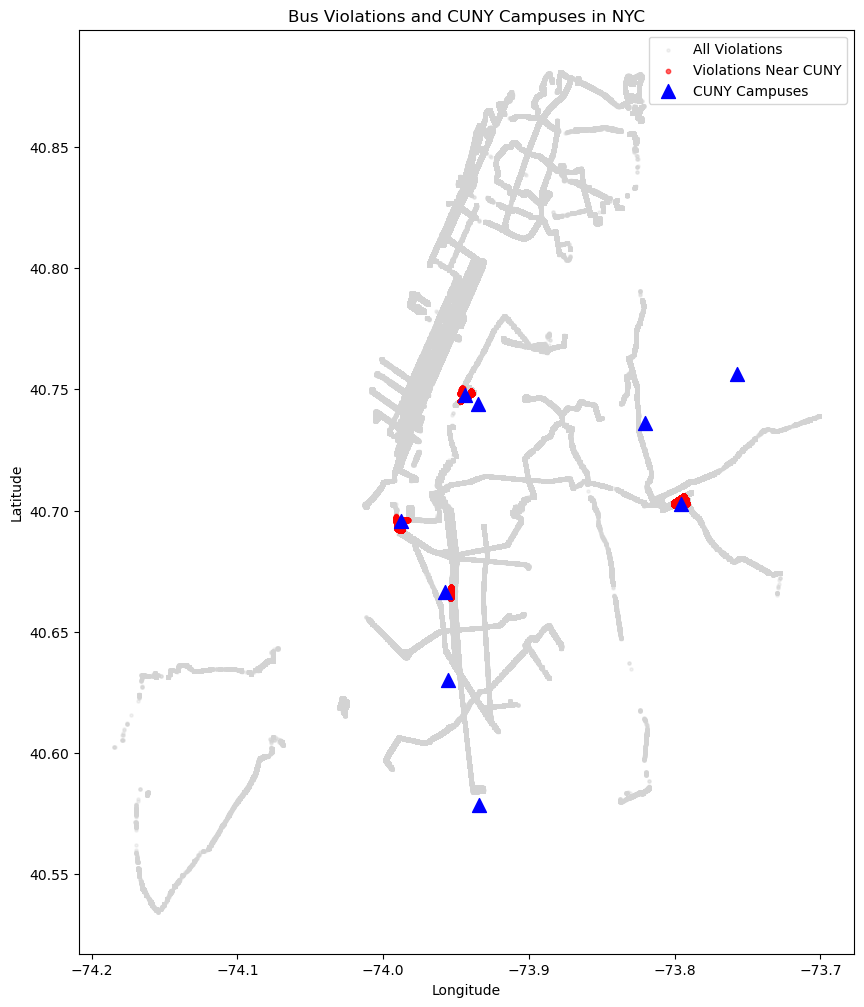

In [86]:
import matplotlib.pyplot as plt

# subset for violations near CUNY
nearCuny = primaryBusData[primaryBusData["isNearCUNY"] == True]

plt.figure(figsize=(10, 12))

# plot ALL violations (light gray)
plt.scatter(
    primaryBusData["Violation_Longitude"],
    primaryBusData["Violation_Latitude"],
    color="lightgray",
    alpha=0.3,
    s=5,
    label="All Violations"
)

# plot violations NEAR CUNY in red
plt.scatter(
    nearCuny["Violation_Longitude"],
    nearCuny["Violation_Latitude"],
    color="red",
    alpha=0.6,
    s=10,
    label="Violations Near CUNY"
)

# plot CUNY campuses as blue triangles
plt.scatter(
    cunyData["Longitude"],
    cunyData["Latitude"],
    color="blue",
    marker="^",
    s=100,
    label="CUNY Campuses"
)

plt.xlabel("Longitude")
plt.ylabel("Latitude")
plt.title("Bus Violations and CUNY Campuses in NYC")
plt.legend()
plt.show()


In [87]:
# we can see that most are actually not near cuny campuses ! now i will analyze if the violations were during peak times

In [88]:
print(primaryBusData["First_Occurrence"].head(10)) # seeing what the values are stored as

0    08/20/2025 11:12:08 PM
1    08/20/2025 11:48:59 PM
2    08/20/2025 10:33:13 PM
3    08/20/2025 10:50:45 PM
4    08/20/2025 10:52:57 AM
5    08/20/2025 11:35:29 PM
6    08/20/2025 11:24:06 PM
7    08/20/2025 10:44:38 PM
8    08/20/2025 11:19:02 PM
9    08/20/2025 11:15:31 PM
Name: First_Occurrence, dtype: object


In [89]:
# convert object to datetime

primaryBusData["First_Occurrence"] = pd.to_datetime(primaryBusData["First_Occurrence"], format="%m/%d/%Y %H:%M:%S %p")
print(primaryBusData["First_Occurrence"].head())

0   2025-08-20 11:12:08
1   2025-08-20 11:48:59
2   2025-08-20 10:33:13
3   2025-08-20 10:50:45
4   2025-08-20 10:52:57
Name: First_Occurrence, dtype: datetime64[ns]


In [90]:
# peak hours defined as 7-10 am and 4-7 pm

In [91]:
def is_peak_hour(dt):
    if pd.isnull(dt):
        return False
    hour = dt.hour
    return (7 <= hour < 10) or (16 <= hour < 19)

primaryBusData["isPeakHour"] = primaryBusData["First_Occurrence"].apply(is_peak_hour)

In [92]:
# filter violations near CUNY 
nearCunyViolations = primaryBusData[primaryBusData["isNearCUNY"] == True]

In [93]:
nearCunyViolations = primaryBusData[primaryBusData["isNearCUNY"] == True].copy()
nearCunyViolations["isFalseViolation"] = nearCunyViolations["Violation_Status"] == "False Positives"

peakFalse = nearCunyViolations[nearCunyViolations["isPeakHour"] & nearCunyViolations["isFalseViolation"]].shape[0]
nonpeakFalse = nearCunyViolations[~nearCunyViolations["isPeakHour"] & nearCunyViolations["isFalseViolation"]].shape[0]


In [94]:
print(nearCunyViolations["isPeakHour"].value_counts())
print(nearCunyViolations["falsePositives"].value_counts())

isPeakHour
False    40603
True     13756
Name: count, dtype: int64
falsePositives
False    44895
True      9464
Name: count, dtype: int64


In [95]:
peakFalseCount = nearCunyViolations[(nearCunyViolations["isPeakHour"]) & (nearCunyViolations["falsePositives"])].shape[0]
nonPeakFalseCount = nearCunyViolations[(~nearCunyViolations["isPeakHour"]) & (nearCunyViolations["falsePositives"])].shape[0]

print(f"False violations during peak hours: {peakFalseCount}")
print(f"False violations during non-peak hours: {nonPeakFalseCount}")


peakTotal = nearCunyViolations[nearCunyViolations["isPeakHour"]].shape[0]
nonPeakTotal = nearCunyViolations[~nearCunyViolations["isPeakHour"]].shape[0]

peakFalsePct = peakFalseCount / peakTotal * 100
nonPeakFalsePct = nonPeakFalseCount / nonPeakTotal * 100

print(f"Percentage of false violations during peak hours: {peakFalsePct:.2f}%")
print(f"Percentage of false violations during non-peak hours: {nonPeakFalsePct:.2f}%")

False violations during peak hours: 2698
False violations during non-peak hours: 6766
Percentage of false violations during peak hours: 19.61%
Percentage of false violations during non-peak hours: 16.66%


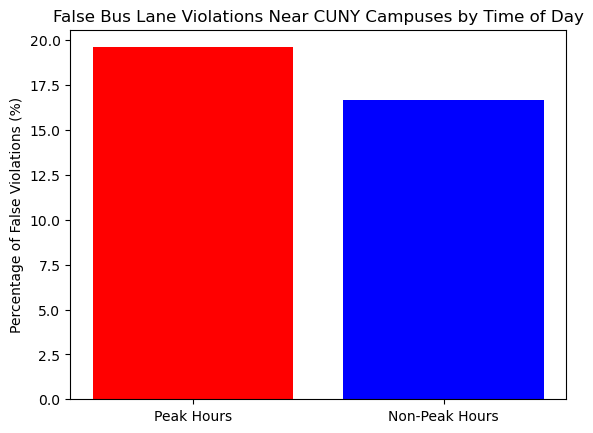

In [96]:
plt.bar(["Peak Hours", "Non-Peak Hours"], [peakFalsePct, nonPeakFalsePct], color=["red", "blue"])
plt.ylabel("Percentage of False Violations (%)")
plt.title("False Bus Lane Violations Near CUNY Campuses by Time of Day")
plt.show()